In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [1]:
import numpy as np
from numpy import pi,cos,sin,exp
import matplotlib.pyplot as plt

In [2]:
# Parameters
k0 = 0 # uniform prior of LTM
k1 = 50 # 1/(2D) diffusion of WM at every time step
k2 = 10 # discrepency between WM and LTM
l_LTM = 1e-2 # update rate of LTM
N = 200 # number of nodes
M = 10  # number of atrractors in LTM
## Define STDP and Phase coupling function
    ## from Lengyel 2005
A_STDP = 0.03
s_STDP = 4
T_theta = 125 # theta oscillation period in ms
dp = lambda dt: dt*2*pi/T_theta # dt = xi - xj
omega = lambda dx: A_STDP * exp(s_STDP*cos(dx)) * sin(dx)
domega = lambda dx: 2*pi/T_theta*A_STDP*exp(s_STDP*cos(dx)) * (cos(dx) - s_STDP * sin(dx)**2 )
    # derivative in respect to xi

In [3]:
## Create LTM attractor landscape
xMemory = np.random.vonmises(0,k0,(N,M))
W = np.zeros((N,N))
for i in range(N):
    for j in range(i): # 0<=j<i
        for k in range(M):
            W[i,j] += omega(xMemory[i,k]-xMemory[j,k])
            W[j,i] += omega(xMemory[j,k]-xMemory[i,k])
sigma2_W = np.var(W.flatten()) # variance 


In [4]:
# initialization
x_target = xMemory[:,0].copy()
x_tilde_init = np.random.vonmises(x_target,k2)
x_hat_init = x_tilde_init.copy()#np.random.vonmises(0,k0,N)


In [5]:
# define a solver for solving k1*sin(x3-x1) + k2*sin(x3-x2) = 0
def diagonalDegree(x1,x2,k1,k2):
    return x1 + np.arctan(sin(x2-x1)/(k1/k2+cos(x2-x1)))
    # or x3 = x2 - np.arctan(sin(x2-x1)/(k2/k1+cos(x2-x1)))
# x1 = np.random.vonmises(0,0)
# x2 = np.random.vonmises(0,0)
# x3 = diagonalDegree(x1,x2,k1,k2)
# print(k1*sin(x3-x1))
# print(k2*sin(x3-x2))


In [6]:
# main iteration equation
def oneStep(x_hat,x_tilde,t):
    ## alternation 0: estimate LTM by W and WM
    H = np.zeros(N) # synaptic interaction term
    for i in range(N):
        dxi = x_hat[i] - x_hat # dxi[j] = x[i] - x[j]
        H[i] = np.dot( W[i,:], domega(dxi) ) # H[i] = \sum_j W_{ij} * domega(xi-xj)
    #
    LTM_prior = - k0*sin(x_hat)
    LTM_synapse = H/sigma2_W
    LTM_cue =   - k2*sin(x_hat-x_tilde)
    x_hat_new = x_hat + l_LTM * (LTM_prior+LTM_synapse+LTM_cue)
    ## alternation 1
    x_tilde_diffused = np.random.vonmises(x_tilde,k1)
    if t>=0:
        x_tilde_new = diagonalDegree(x_tilde_diffused,x_hat,k1,k2)
    else: x_tilde_new = x_tilde_diffused
    ##
    x_hat_new = np.mod(x_hat_new+pi,2*pi)-pi
    x_tilde_new = np.mod(x_tilde_new+pi,2*pi)-pi
    return x_hat_new,x_tilde_new



In [7]:
# solve
x_hat_t   = [x_hat_init]
x_tilde_t = [x_tilde_init]
for t in range(1000):
    x_hat_new,x_tilde_new = oneStep(x_hat_t[-1],x_tilde_t[-1],t)
    x_hat_t.append(x_hat_new)
    x_tilde_t.append(x_tilde_new)

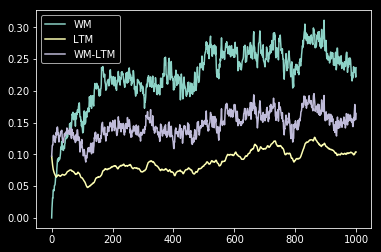

In [8]:
# plot
error_WM  = [np.mean((np.mod(x_tilde-x_tilde_init+pi,2*pi)-pi)**2) for x_tilde in x_tilde_t]
plt.plot(error_WM,label='WM')
error_LTM = [np.mean((np.mod(x_hat-x_target+pi,2*pi)-pi)**2) for x_hat in x_hat_t]
plt.plot(error_LTM,label='LTM')
error_d = [np.mean((np.mod(x_tilde-x_target+pi,2*pi)-pi)**2) for x_tilde in x_tilde_t]
plt.plot(error_d,label='WM-LTM')
plt.legend()

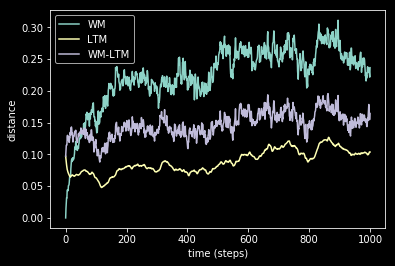

In [11]:
# plot
error_WM  = [np.mean((np.mod(x_tilde-x_tilde_init+pi,2*pi)-pi)**2) for x_tilde in x_tilde_t]
plt.plot(error_WM,label='WM')
error_LTM = [np.mean((np.mod(x_hat-x_target+pi,2*pi)-pi)**2) for x_hat in x_hat_t]
plt.plot(error_LTM,label='LTM')
error_d = [np.mean((np.mod(x_tilde-x_target+pi,2*pi)-pi)**2) for x_tilde in x_tilde_t]
plt.plot(error_d,label='WM-LTM')
plt.xlabel('time (steps)')
plt.ylabel('distance')
plt.legend()